# Example notebook 

This notebook is a copy from `examples/getting_started/0_Getting_started/0_Getting_started.ipynb` with a small modifications for use with [Papermill](https://github.com/nteract/papermill) and Amazon Braket Hybrid Jobs. 

## Papermill parameters

Papermill is a tool for parameterizing, executing, and analyzing Jupyter Notebooks. 
To parameterize a notebook, we need tag a cell that contains all the parameters. 
We can only tag one cell, and for simplicity we place it at the top of the notebook. 
Full instructions are available here https://papermill.readthedocs.io/en/latest/usage-parameterize.html#designate-parameters-for-a-cell. 

Below, we tag the parameter `shots=1000`. 
We can then run the notebook as usual cell-by-cell to see the results. 

We additionally add two Braket specific parameters called `device_arn` and `results_dir`. 
These will be overriden when running a Hybrid Job. 

**In the following cell, we added a tag called `parameters` for Papermill to recognize. If you don't see the tag, follow the instructions above.**

In [1]:
# Papermill parameters
shots = 1000

# Braket specific parameters
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
results_dir = "."

In [2]:
# Parameters
shots = 1000
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
results_dir = "/opt/braket/model"

# Getting started with Amazon Braket

In this tutorial we prepare a maximally entangled Bell state between two qubits. 
We then run our circuit on a local simulator and obtain the results.

In [3]:
import time

import matplotlib.pyplot as plt

%matplotlib inline

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.jobs.metrics import log_metric
from braket.tracking import Tracker  # cost tracker

cost_tracker = Tracker().start()

## Build a circuit

Let's build a Bell state with two qubits. By calling `Circuit()` we create an empty circuit, and we can just add gates to the circuit. 

In [4]:
# build a Bell state with two qubits.
bell = Circuit().h(0).cnot(control=0, target=1)
print(bell)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


## Submit the circuit to the local simulator and obtain the results

Next, we choose either a local simualtor or an Amazon Braket device. 

In [5]:
# set up device
if "local" in device_arn:
    device = LocalSimulator()
else:
    device = AwsDevice(device_arn)

In [6]:
# Run the circuit and get results
result = device.run(bell, shots=shots).result()

# get measurement shots
counts = result.measurement_counts
counts = {k: counts[k] for k in sorted(counts)}  # sort results
print(counts)

{'00': 506, '11': 494}


Hybrid Jobs enables logging of metrics during the job. 
In the example below, we track the total cost of running the circuit on simulators or QPUs by using the cost tracker.

We also track the number of counts in the "00" state. It is best practice to log all metrics per iteration at a common timestamp to avoid duplication.

In [7]:
total_cost = float(cost_tracker.simulator_tasks_cost() + cost_tracker.qpu_tasks_cost())

timestamp = time.time()

log_metric(metric_name="cost", value=float(total_cost), timestamp=timestamp)

log_metric(metric_name="counts_00", value=counts["00"], timestamp=timestamp)

Metrics - timestamp=1676997606.1576412; cost=0.00375;
Metrics - timestamp=1676997606.1576412; counts_00=506;


**The following cell saves the results to a file**

The use of `results_dir` is that any results are saved to the correct directory when called from a Braket Job. Below, we save the measurement counts to a .pkl file. 

In [8]:
import pickle

# save meaurement counts to a file
with open(f"{results_dir}/results.pkl", "wb") as f:
    pickle.dump(counts, f)


# re-load the results with
# with open(f"{results_dir}/results.pkl", 'rb') as f:
#    counts = pickle.load(f)

**The following cell saves the figure to a file**

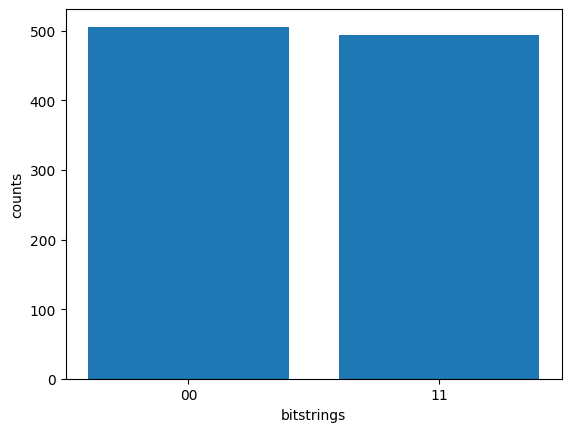

In [9]:
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstrings")
plt.ylabel("counts")

# Save figure to a local directory or Amazon S3 location
plt.savefig(f"{results_dir}/histogram.png")